In [270]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, normalize
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [271]:
df = pd.read_csv('../Datasets/FishClassificationDataset/Fish.csv')
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [272]:
headings = df.columns.tolist()
headings.remove('Species')

In [273]:
embedding_dict = {}
embedding_list = []
counter = 0
for species in df['Species'].unique():
    embedding_dict[species] = counter
    counter += 1
for species in df['Species']:
    embedding_list.append(embedding_dict[species])
df['Species_encoding'] = embedding_list

In [274]:
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,Species_encoding
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,0
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,0
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,0
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,0
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,0


In [275]:
y_train = np.array(embedding_list)
x_train = np.stack([df[i].values for i in headings], axis=1, )

In [276]:
x_train = normalize(x_train, axis=0)


In [277]:
class Model(nn.Module):
    def __init__(self, in_features=6, h1=12, h2=16, out_features=7):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return F.log_softmax(x, dim=1)

In [278]:
torch.manual_seed(12345)
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [279]:
epochs =20000
losses = []

for i in range(epochs):
    i+=1
    input = torch.FloatTensor(x_train)
    labels = torch.LongTensor(y_train)
    optimizer.zero_grad()
    y_pred = model.forward(input)
    loss = criterion(y_pred, labels)
    losses.append(loss.item())

    if i%1000 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    loss.backward()
    optimizer.step()


epoch:  1  loss: 2.00484538
epoch: 1001  loss: 0.17564531
epoch: 2001  loss: 0.10880651
epoch: 3001  loss: 0.07129811
epoch: 4001  loss: 0.04091895
epoch: 5001  loss: 0.01254385
epoch: 6001  loss: 0.00373065
epoch: 7001  loss: 0.00140946
epoch: 8001  loss: 0.00067334
epoch: 9001  loss: 0.00034056
epoch: 10001  loss: 0.00017837
epoch: 11001  loss: 0.00009517
epoch: 12001  loss: 0.00005135
epoch: 13001  loss: 0.00002802
epoch: 14001  loss: 0.00001546
epoch: 15001  loss: 0.00000856
epoch: 16001  loss: 0.00000477
epoch: 17001  loss: 0.00000268
epoch: 18001  loss: 0.00000151
epoch: 19001  loss: 0.00000085


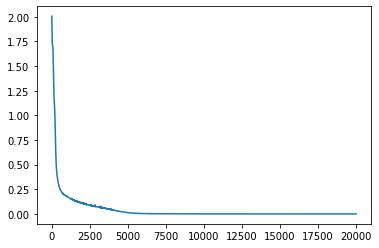

In [280]:
plt.plot(range(epochs), losses)
